In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
from pandas_datareader import data
import requests
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
portfolio = 1e5 #Portfolio total worth of 1 lakh
tscost = 0.005 #Per trade transaction cost of 0.5%, so if two stocks of 30 each are bought, (1+0.005)*2*30 is charged in total
nstocks = 0

stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS'] #Stock list, to add a stock simply
                                                                           #add the ticker according to Yahoo! Finance
for stock in stock_list:
    nstocks+=1          #Calculates number of stocks according to input stock list

In [3]:
#Function to read Data
def readData(ticker, n):
    stocks.append(data.DataReader(ticker, 'yahoo',start='1/1/2015')) #Taking backtesting period as roughly 5 years
    

In [4]:
#Defines Bollinger Bands of each ticker
def BBands(df1):
    window = 25
    no_of_std = 2
    rolling_mean1 = df1['Adj Close'].rolling(window).mean()
    rolling_std1 = df1['Adj Close'].rolling(window).std()
    
    df1['Bollinger High'] = rolling_mean1 + (rolling_std1 * no_of_std)
    df1['Bollinger Mid'] = rolling_mean1
    df1['Bollinger Low'] = rolling_mean1 - (rolling_std1 * no_of_std)
    df1['Position'] = 0   


In [5]:
#Defines the Position based on a Bollinger Band strategy as defined below:

########################################################################################################################
#Entry:  -If today's close, adjusted, is lesser than todays Bollinger High AND yesterdays close was greater than       #                                                                                                                       #
#        yesterday's Bollinger High, AND the market is trending down for a day, then SHORT Position                    #
#        -Similar for long position                                                                                    #
#                                                                                                                      #
#Exit: -If short yesterday there was a short position, then exit trade either if todays close becomes lower than todays#                                                                                                                    #
#       Bollinger Mid, or if the todays close becomes greater than todays bollinger high, ie, crossover again          #                                                                                                    #
#      -Similar for long entry-exit                                                                                    #                           
#                                                                                                                      #
########################################################################################################################


def BBandStrategy(df1):
    for row in range(len(df1)):
        if(df1['Position'].iloc[row-1]==0):
            if (df1['Adj Close'].iloc[row] < df1['Bollinger High'].iloc[row]) and (df1['Adj Close'].iloc[row-1] > df1['Bollinger High'].iloc[row-1]) and (df1['Adj Close'].iloc[row] < df1['Adj Close'].iloc[row-1]):
                df1['Position'].iloc[row] = -1

            if (df1['Adj Close'].iloc[row] > df1['Bollinger Low'].iloc[row]) and (df1['Adj Close'].iloc[row-1] < df1['Bollinger Low'].iloc[row-1])and (df1['Adj Close'].iloc[row] > df1['Adj Close'].iloc[row-1]):
                df1['Position'].iloc[row] = 1

            
        elif (df1['Position'].iloc[row-1]==1):
            if (df1['Adj Close'].iloc[row]>df1['Bollinger Mid'].iloc[row]) or (df1['Adj Close'].iloc[row]<df1['Bollinger Low'].iloc[row]):
                df1['Position'].iloc[row] = 0
            else:
                df1['Position'].iloc[row] = 1

        else:
            if (df1['Adj Close'].iloc[row]<df1['Bollinger Mid'].iloc[row]) or (df1['Adj Close'].iloc[row]>df1['Bollinger High'].iloc[row]):
                df1['Position'].iloc[row] = 0
            else:
                df1['Position'].iloc[row] = -1

    

In [6]:
#Iterating over all the tickers to read data, generate Bollinger Bands and formulate portfolio positions based on strategy
i = 0
stocks = []
for ticker in stock_list:
    readData(ticker,i)
    BBands(stocks[i])
    BBandStrategy(stocks[i])
    i+=1



C:\Users\Sauradeep\AppData\Local\conda\conda\envs\py36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


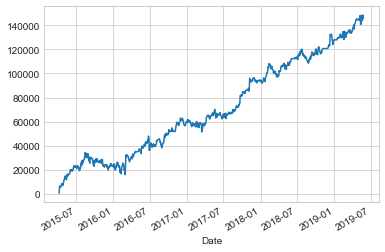

In [11]:

s = (len(stocks[0]),nstocks) #setting the dimensions of the weights vector depending on the available data points
weights = np.zeros(s) 


for row in range(len(stocks[0])):
    i = 0
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['Position'].iloc[row]) #checking how many positions were taken on that day
    for i in range(nstocks):
        if sumwts>0:
            #weights assigned as:
            #weights = (portfolio*position)/(no.of positions * adj close on that day * (1+transac cost))
            weights[row][i]=(portfolio*stocks[i]['Position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))
        else:
            weights[row][i]=0
i = 0


for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1)) #Absolute market return

    
#Calculating portfolio return
stocks[0]['Strategy Return']=0
i = 0
for i in range(nstocks):
    stocks[0]['Strategy Return']+=stocks[i]['Market Return'] * weights[:,i] #multiplying market return of each
                                                                            #ticker with its weight
stocks[0]['Strategy Return'][64:].cumsum().plot() #Plotting strategy return

In [12]:
weights

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       ...,
       [747.57688204,   0.        ,  66.33941326,   0.        ,
          0.        ],
       [  0.        ,   0.        , 130.35829838,   0.        ,
          0.        ],
       [  0.        ,   0.        , 133.86585389,   0.        ,
          0.        ]])